In [1]:
import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial    

In [2]:
"""Define the operators for MZI - we will deal in Heisenberg """
T = Symbol('T')
xvec = np.arange(-30.,30.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
N_dim = 35##Dimenstion of the Hilbert spac

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return factorial(n)/(factorial(n-k)*factorial(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F


In [13]:
#Variable definitions:
#delta = initial coherent state amplitude
# refl(1-3)= beamsplitter r^2 values at each step
# n(1-3) = number of photons detected at each detector
# beta = amplitude of final dispalcement to displace the state back
#alpha = amplitude of SSV state to be compared with.  Note, here
#this can be related to cat state amplitude by amp_cat=alpha/(Cosh[sq]-Sinh[sq])
# sq = the 'r' value, or squeezing parameter. This is the negative of the mathematica results.

'''Three-step check: P -> 0.00179605, 0.9836, r[3.] -> 0.520135, r[2.] -> 0.490869, 
 r[1.] -> 0.637566, \[Alpha] -> 1.349, 
 sq -> -0.476595, \[Beta] -> 2.03846, delta -> 3.53709, n1 -> 5, 
 n2 -> 2, n3 -> 1}'''

refl1=0.637566**2; refl2=0.490869**2; refl3=0.520135**2;
delta=3.53709; beta=2.03846; sq=0.476595; alpha=1.349; n1=5;n2=2;n3=1;

#refl1=1/2; refl2=1/2; refl3=2/3;
#delta=np.sqrt(14); beta=np.sqrt(19/16); sq=0.476595; alpha=1.4; n1=5;n2=3;n3=1;


The probability of a sucessful detection is: 0.07142409504905824
BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x000001A53F4818C8> > state, where my detector has efficiency 1
fidelity with ssv: 0.10947734840458638


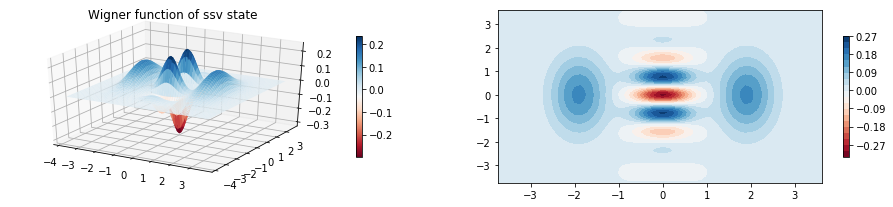

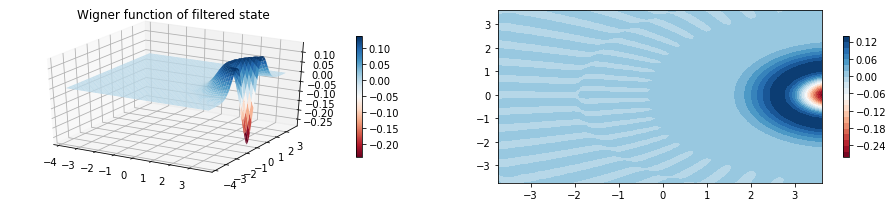

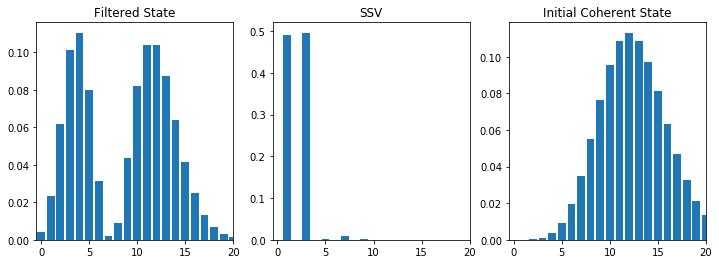

In [14]:
ssv=SSV_minus(sq,alpha)

W_ssv=wigner(ssv,xvec,xvec);
eta=1;

first=Fock_Filter_prob(ket2dm(coherent(N_dim,delta)),1,refl1,n1,eta,N_dim)
W1=wigner(first,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_ssv, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_ssv, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of ssv state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W1, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered state')
fid = fidelity(ssv,first)
print('fidelity with ssv:',fid*fid)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
bar0 = axes[0].bar(range(N_dim), first.diag())

lbl0 = axes[0].set_title("Filtered State")

lim0 = axes[0].set_xlim([-.5, 20])
bar1 = axes[1].bar(range(N_dim), ssv.diag())

lbl1 = axes[1].set_title("SSV")

lim1 = axes[1].set_xlim([-.5, 20])

bar2 = axes[2].bar(range(N_dim), ket2dm(coherent(N_dim,delta)).diag())

lbl2 = axes[2].set_title("Initial Coherent State")

lim2 = axes[2].set_xlim([-.5, 20])

plt.show()

The probability of a sucessful detection is: 0.15531188283788863
BS has reflectivity 0.240952375161  and I am detecting the | <function num at 0x000001A53F4818C8> > state, where my detector has efficiency 1
fidelity with cat: 0.28299188586460117


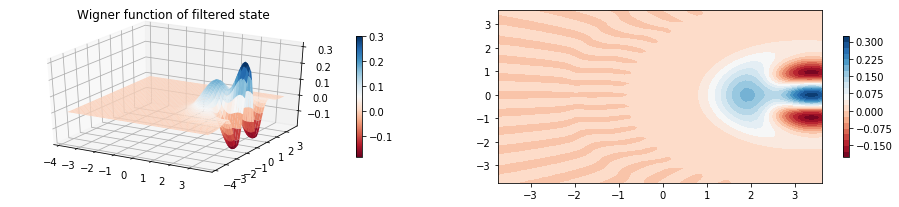

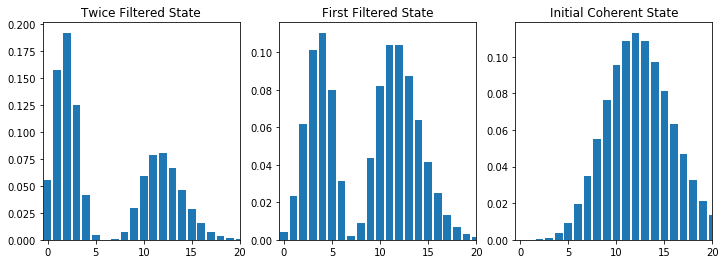

In [15]:
second=Fock_Filter_prob(first,1,refl2,n2,eta,N_dim);
W2=wigner(second,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W2, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered state')
fid = fidelity(ssv,second)
print('fidelity with cat:',fid*fid)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
bar0 = axes[0].bar(range(N_dim), second.diag())

lbl0 = axes[0].set_title("Twice Filtered State")

lim0 = axes[0].set_xlim([-.5, 20])
bar1 = axes[1].bar(range(N_dim), first.diag())

lbl1 = axes[1].set_title("First Filtered State")

lim1 = axes[1].set_xlim([-.5, 20])

bar2 = axes[2].bar(range(N_dim), ket2dm(coherent(N_dim,delta)).diag())

lbl2 = axes[2].set_title("Initial Coherent State")

lim2 = axes[2].set_xlim([-.5, 20])
plt.show()

The probability of a sucessful detection is: 0.1619071293586327
BS has reflectivity 0.270540418225  and I am detecting the | <function num at 0x000001A53F4818C8> > state, where my detector has efficiency 1
fidelity with cat: 0.28299188586460117


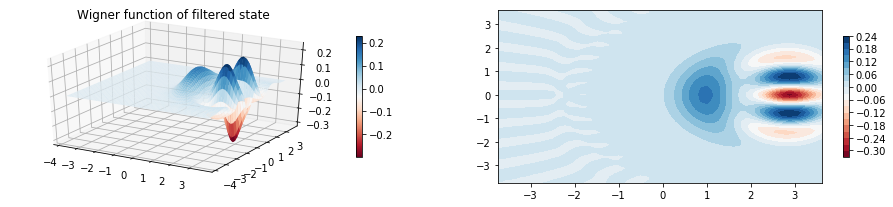

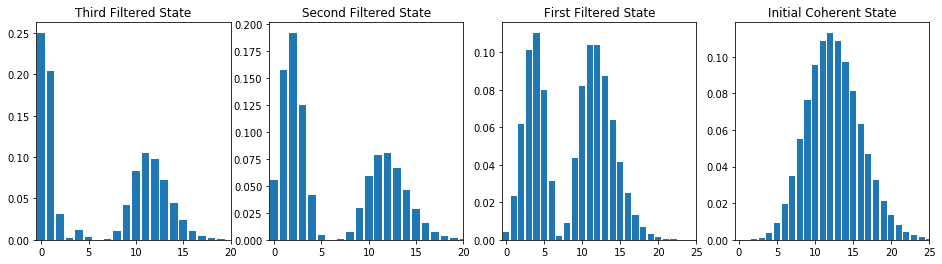

In [18]:
third=Fock_Filter_prob(second,1,refl3,n3,eta,N_dim);
W3=wigner(third,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W3, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of filtered state')
fid = fidelity(ssv,second)
print('fidelity with cat:',fid*fid)

fig, axes = plt.subplots(1, 4, figsize=(16,4))

bar0 = axes[0].bar(range(N_dim), third.diag())

lbl0 = axes[0].set_title("Third Filtered State")

lim0 = axes[0].set_xlim([-.5, 20])
bar1 = axes[1].bar(range(N_dim), second.diag())

lbl1 = axes[1].set_title("Second Filtered State")

lim1 = axes[1].set_xlim([-.5, 20])

bar2 = axes[2].bar(range(N_dim), first.diag())

lbl2 = axes[2].set_title("First Filtered State")

lim2 = axes[2].set_xlim([-.5, 25])

bar3 = axes[3].bar(range(N_dim), ket2dm(coherent(N_dim,delta)).diag())

lbl3 = axes[3].set_title("Initial Coherent State")

lim3 = axes[3].set_xlim([-.5, 25])
plt.show()

fidelity with ssv: 0.9828908955120575


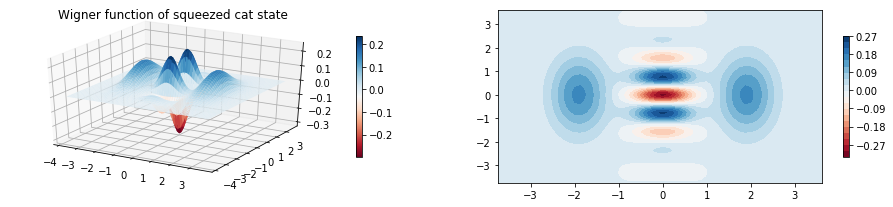

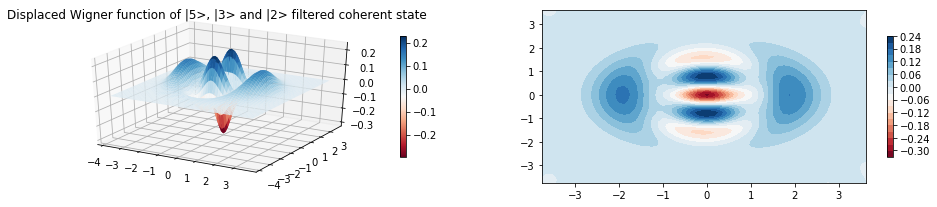

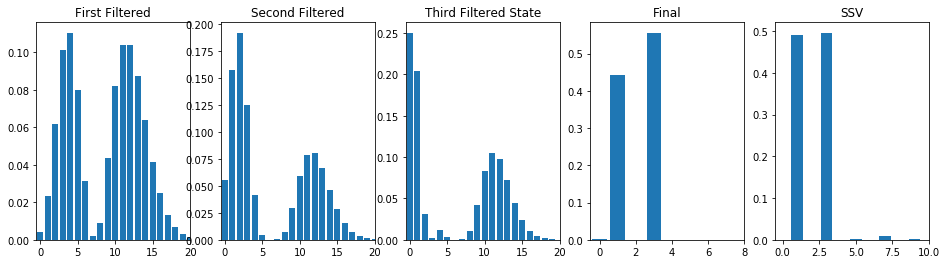

In [17]:
final_state=D(third,beta*(-1))

W_final=wigner(final_state,xvec,xvec)


fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_ssv, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_ssv, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of squeezed cat state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_final, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_final, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Displaced Wigner function of |5>, |3> and |2> filtered coherent state')
fid = fidelity(ssv,final_state)
print('fidelity with ssv:',fid*fid)
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(16,4))


bar0 = axes[0].bar(range(N_dim), first.diag())

lbl0 = axes[0].set_title("First Filtered")

lim0 = axes[0].set_xlim([-.5, 20])


bar1 = axes[1].bar(range(N_dim), second.diag())

lbl1 = axes[1].set_title("Second Filtered")

lim1 = axes[1].set_xlim([-.5, 20])


bar2 = axes[2].bar(range(N_dim), third.diag())

lbl2 = axes[2].set_title("Third Filtered State")

lim2 = axes[2].set_xlim([-.5, 20])

bar3 = axes[3].bar(range(N_dim), final_state.diag())

lbl3 = axes[3].set_title("Final")

lim3 = axes[3].set_xlim([-.5, 8])


bar4 = axes[4].bar(range(N_dim), ssv.diag())

lbl4 = axes[4].set_title("SSV")

lim4 = axes[4].set_xlim([-.5, 10])
plt.show()


In [84]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=1, midpoint=0, stop=0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = cm.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
#from matplotlib import rc,rcParams
#from pylab import *

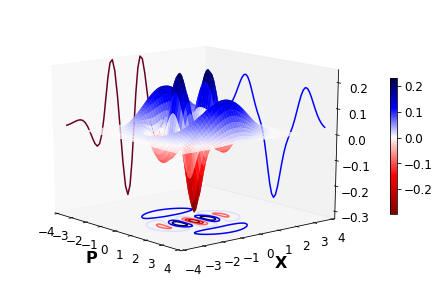

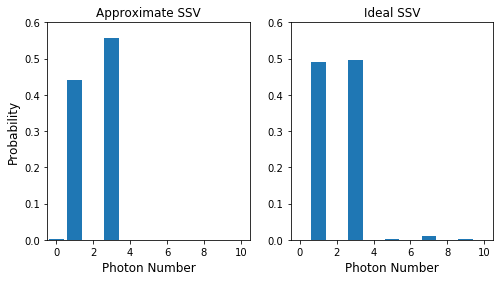

In [133]:
#activate latex text rendering
#rc('text', usetex=True)
#rc('axes', linewidth=2)
#rc('font', weight='bold')
#rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

xvec = np.arange(-26.,26.)*5./40
yvec = np.arange(-35.,35.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
W=wigner(final_state,xvec,xvec);
orig_cmap = cm.seismic

shifted_cmap1 = shiftedColorMap(orig_cmap, midpoint=1-(W.max()/(W.max()-W.min())), name='shifted')
         
         
fig = plt.figure(figsize=(8,5))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot

ax1 = fig.add_subplot(1,1,1, projection='3d')
p = ax1.plot_surface(X, Y, W, rstride=1,cstride=1, cmap=shifted_cmap1, linewidth=0.5)
#lim=ax1.set_xlim([-4,2])
#lim=ax1.set_ylim([-1,1])

cb = fig.colorbar(p, shrink = 0.5)
cb.ax.tick_params(labelsize=12)
ax1.contour(X, Y, W, cmap=shifted_cmap1,linestyles="solid", offset=-0.35)
ax1.set_xlim([-4,4])
ax1.set_ylim([-4,4])
ax1.view_init(15, -40)

ax1.contour(X, Y, W,[0], zdir='y',cmap=cm.bwr,offset=4.5)
ax1.contour(X, Y, W,[0], zdir='x',cmap=cm.RdBu, offset=-4.5)
#plt.axis('off')
ax1.grid(b=False)
#plt.xlabel('P',fontsize=16,fontweight='heavy')
plt.xlabel('P',fontsize=16,fontweight='heavy')
plt.ylabel('X',fontsize=16,fontweight='heavy')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.zaxis.set_tick_params(labelsize=12)

fig2 = plt.figure(figsize=(8,4))
ax1=fig2.add_subplot(1,2,1)
ax1.bar(range(N_dim),final_state.diag())
lim1 = ax1.set_xlim([-.5, 10.5])
lim1y = ax1.set_ylim([0,0.6])
plt.ylabel('Probability',fontsize='large')
plt.xlabel('Photon Number',fontsize='large')
plt.title('Approximate SSV')

ax2=fig2.add_subplot(1,2,2)
ax2.bar(range(N_dim),ssv.diag())
lim2 = ax2.set_xlim([-.5, 10.5])
lim2y = ax2.set_ylim([0,0.6])
plt.xlabel('Photon Number',fontsize='large')
plt.title('Ideal SSV')
#plt.subplots_adjust(wspace=0)
plt.show()

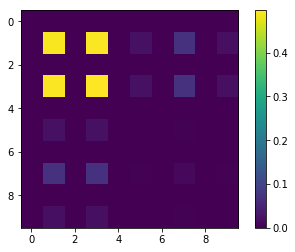

In [10]:
'''Now plot the density matrix elements of the ideal state with that of 
the approximate state resulting from photon-catalysis'''
s=np.abs((ssv.full()))
temp=np.delete(s,np.s_[10:],0)
state=np.delete(temp,np.s_[10:],1)
plt.imshow(state)
plt.colorbar()
plt.show()

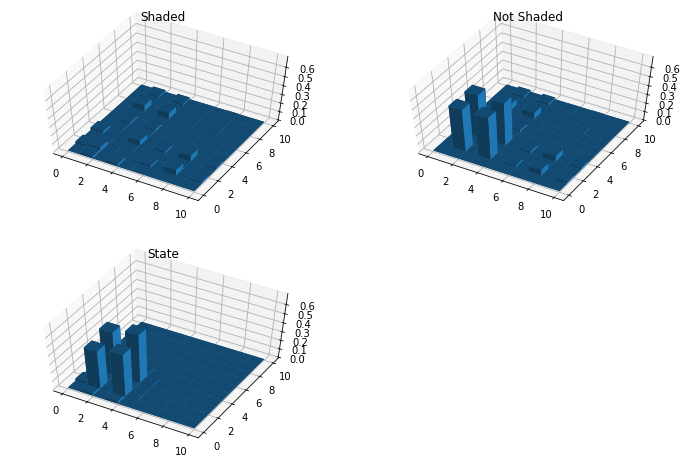

In [234]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')

# fake data
_x = np.arange(10)
_y = np.arange(10)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

#top = x + y
diff=state.ravel()-state2.ravel()
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y,0,1,1, np.abs(diff), shade=True)
ax1.set_title('Shaded')
ax1.set_zlim([0,.7])

ax2.bar3d(x, y, 0, 1,1, state.ravel(), shade=True)
ax2.set_title('Not Shaded')
ax2.set_zlim([0,.7])

ax3.bar3d(x, y, 0, 1,1, state2.ravel(), shade=True)
ax3.set_title('State')
ax3.set_zlim([0,.7])
ax1.view_init(55, -60)
ax2.view_init(55, -60)
ax3.view_init(55, -60)

plt.show()

In [30]:
z=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

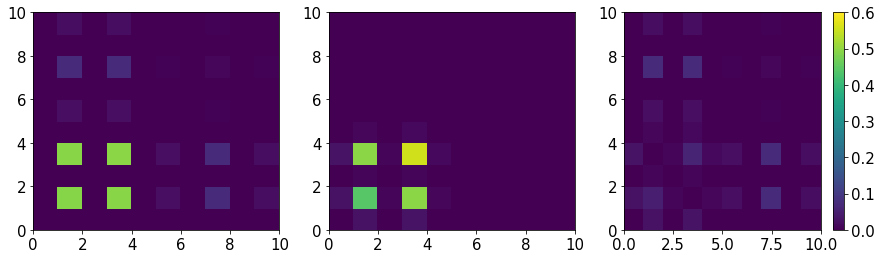

In [226]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
heatmap = ax[0].pcolor(state,vmin=0.0, vmax=0.6)
heatmap = ax[1].pcolor(state2,vmin=0.0, vmax=0.6)
heatmap = ax[2].pcolor(np.abs(state-state2),vmin=0.0, vmax=0.6)
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=15)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[2].tick_params(labelsize=15)
plt.show()

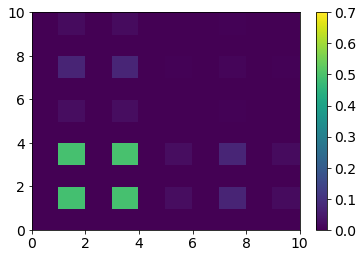

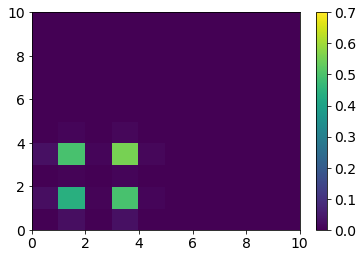

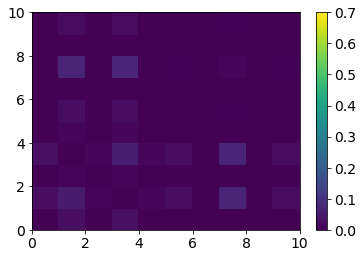

In [243]:
s=np.abs((ssv.full()))
temp=np.delete(s,np.s_[10:],0)
state=np.delete(temp,np.s_[10:],1)


s2=np.abs((final_state.full()))
temp1=np.delete(s2,np.s_[10:],0)
state2=np.delete(temp1,np.s_[10:],1)

#plt.imshow(state)
fig = plt.figure(figsize=(6,4))
plt.pcolormesh(state, vmin=0.0, vmax=0.7)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.show()


#plt.imshow(state2)
fig = plt.figure(figsize=(6,4))
plt.pcolormesh(state2, vmin=0.0, vmax=0.7)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.show()

fig = plt.figure(figsize=(6,4))
plt.pcolormesh(np.abs(state2-state), vmin=0.0, vmax=0.7)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.show()

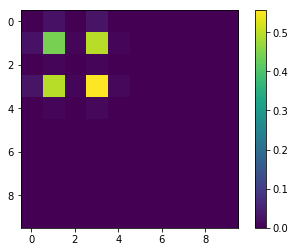

In [87]:
s2=np.abs((final_state.full()))
temp1=np.delete(s2,np.s_[10:],0)
state2=np.delete(temp1,np.s_[10:],1)
plt.imshow(state2)
plt.colorbar()
plt.show()

In [13]:
myarray=np.array([[5,1,5,77],[6,2,5,2],[7,3,5,3],[8,4,5,4],[8,9,6,2]])
new=np.delete(myarray,np.s_[2:],0)
final=np.delete(new,np.s_[2:],1)

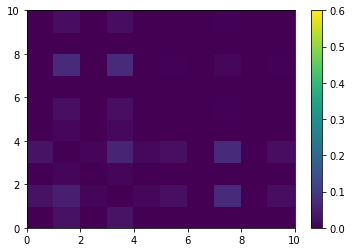